<center><h1 style="color:purple;">CUSTOMER SEGMENTATION</h1></center>

Customer segmentation is the process of dividing a customer base into smaller groups of individuals that have similar needs or characteristics. The segmentation can be based on various criteria such as demographics, behavior, and psychographics. The goal of customer segmentation is to identify high yield segments – that is, those segments that are likely to be the most profitable or that have growth potential – in order to target them specifically. By identifying and understanding specific segments, companies can tailor their products, services, and marketing campaigns to the specific needs and wants of those groups, which can lead to increased customer satisfaction and ultimately, increased revenue.

I worked on "customer segmentation" in this project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
from pathlib import Path
from scipy.spatial.distance import cdist
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
from PIL import Image
import requests
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# read the datafile
df_initial = pd.read_csv('data.csv',encoding="ISO-8859-1")

I found my dataset from "https://www.kaggle.com/code/fabiendaniel/customer-segmentation" and imported it with pandas library. I used 'encoding="ISO-8859-1"' parameter because there was some strings in my dataset that doesn't suit utf-8 encoding.

My dataframe contains 8 variables that correspond to:

-InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.<br>
-StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.<br>
-Description: Product (item) name. Nominal.<br>
-Quantity: The quantities of each product (item) per transaction. Numeric.<br>
-InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.<br>
-UnitPrice: Unit price. Numeric, Product price per unit in sterling.<br>
-CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.<br>
-Country: Country name. Nominal, the name of the country where each customer resides.<br>

# Data Preprocessing

Data preprocessing is the process of preparing raw data for analysis. This can include cleaning, generally analysing and transforming the data, as well as reducing its dimensionality. The goal is to make the data as clean and usable as possible before applying any deeper analysis or modeling techniques.

### General Observation

In order to make my raw data ready for deeper analysis or modeling techniques, first of all I made general observation to get general knowledge about its dimensions, length, etc.

In [3]:
print("Total Number of Data:", "We have totally {} number of rows".format(df_initial.shape[0]))
print("Total Number of Attributes:", "We have totally {} number of attributes".format(df_initial.shape[1]))
df_initial.head()

Total Number of Data: We have totally 541909 number of rows
Total Number of Attributes: We have totally 8 number of attributes


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom

So here I observed length, atributes and head of my data. Totally I have 541909 data which is a good number for customer segmentation.

In [4]:
print("Number of different product types:",len(df_initial['StockCode'].value_counts()))
print("Number of different customers:",len(df_initial['CustomerID'].value_counts()))

Number of different product types: 4070
Number of different customers: 4372


My dataset includes 4372 different customers so we can say that it contains around 100-150 purchase records per customer.

In [5]:
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'count of null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.count()).T.rename(index={0:'count of non-null values'}))
tab_info=tab_info.append(pd.DataFrame(round(df_initial.isnull().sum()/df_initial.shape[0]*100, 2)).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

InvoiceNo StockCode Description Quantity InvoiceDate  \
column type                 object    object      object    int64      object   
count of null values             0         0        1454        0           0   
count of non-null values    541909    541909      540455   541909      541909   
null values (%)                0.0       0.0        0.27      0.0         0.0   

                         UnitPrice CustomerID Country  
column type                float64    float64  object  
count of null values             0     135080       0  
count of non-null values    541909     406829  541909  
null values (%)                0.0      24.93     0.0

As you can see above, it contains some null values in "Description" and "CustomerID" columns. Especially almost a quarter of "CustomerID" column is missing. So we can't ignore it. Additionally, some column type (like "InvoiceDate" column) can be changed in the data cleaning phase to use them more effectively.

### Data Cleaning

Data cleaning is the process of identifying and correcting or removing errors and inconsistencies in data. This can include dealing with missing or duplicate data, correcting data entry errors, and dealing with outliers or other unexpected values. The goal is to ensure that the data is accurate and consistent, so that it can be used effectively for analysis and decision-making.

In [6]:
df_initial = df_initial.astype({"InvoiceDate": "datetime64[ns]"})

Firstly, I changed type of "InvoiceDate" column because in the future I'm planning to split it as months and years and group it to get deeper vision about dataset.

In [7]:
df_initial = df_initial.dropna()

df_initial = df_initial.astype({"CustomerID": "int"})

Then I directly dropped rows if it include any null values. I didn't use threshold or something else here because we have null values only under "Description" and "CustomerID" columns. "Description" column includes very few number of null values(about 0.2 percent of our dataset) so I didn't hesitated to drop them directly. "CustomerID" column includes too many null values but we are dealing with customer segmentation problem and we can not do it without customer knowledge so I dropped them directly too.

In [8]:
print('Duplicated Entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicated Entries: 5225


Then I found 5225 duplicated records which are probably incorrectly recorded so I dropped them too.

In [9]:
len(df_initial)

401604

After these cleaning processes we got 401604 records left.

In [10]:
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'count of null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.count()).T.rename(index={0:'count of non-null values'}))
tab_info=tab_info.append(pd.DataFrame(round(df_initial.isnull().sum()/df_initial.shape[0]*100, 2)).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

InvoiceNo StockCode Description Quantity  \
column type                 object    object      object    int64   
count of null values             0         0           0        0   
count of non-null values    401604    401604      401604   401604   
null values (%)                0.0       0.0         0.0      0.0   

                             InvoiceDate UnitPrice CustomerID Country  
column type               datetime64[ns]   float64      int32  object  
count of null values                   0         0          0       0  
count of non-null values          401604    401604     401604  401604  
null values (%)                      0.0       0.0        0.0     0.0

And printed same table at the beginning and as you can see in this table we don't have any null values now.

In [11]:
df_initial.loc[df_initial['Description'] == "WHITE METAL LANTERN"].head()

InvoiceNo StockCode          Description  Quantity         InvoiceDate  \
1      536365     71053  WHITE METAL LANTERN         6 2010-12-01 08:26:00   
50     536373     71053  WHITE METAL LANTERN         6 2010-12-01 09:02:00   
67     536375     71053  WHITE METAL LANTERN         6 2010-12-01 09:32:00   
279    536396     71053  WHITE METAL LANTERN         6 2010-12-01 10:51:00   
417    536406     71053  WHITE METAL LANTERN         8 2010-12-01 11:33:00   

     UnitPrice  CustomerID         Country  
1         3.39       17850  United Kingdom  
50        3.39       17850  United Kingdom  
67        3.39       17850  United Kingdom  
279       3.39       17850  United Kingdom  
417       3.39       17850  United Kingdom

Here I printed rows of an example product according to its "Desciption". And I noticed that "StockCode" values don't change for products with same "Description". So we can infer that "Description" == "Stock Code".

In [12]:
df_initial['Country'] = df_initial['Country'].replace(['EIRE'], 'Ireland')

And while looking at dataset, I noticed that "Ireland" country recorded as "EIRE" so I changed it for better understanding.

### Data Visualization

Data visualization is the technique of representing data in a graphical format, such as using charts, graphs, and maps. It can be used to present data in a way that is easy to understand, and to uncover patterns and insights that might not be apparent from looking at the raw data alone. The goal of data visualization is to communicate complex information in a simple, intuitive way.

##### Grouping Sales By Date

I started to visualize data with grouping sales by date. Because I was curious about data distribution on different dates.

In [13]:
df_initial['year'] = [d.year for d in df_initial['InvoiceDate']]
df_initial['month'] = [d.month for d in df_initial['InvoiceDate']]
df_initial.drop(['InvoiceDate'], axis=1, inplace=True)

To do that I splitted 'InvoiceDate' column as 'year' and 'month' columns and removed it from my dataframe because I had nothing else to do with that column.

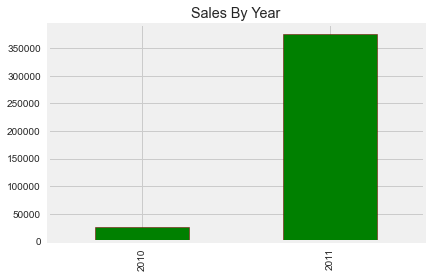

In [14]:
df_initial['year'].value_counts().plot.bar(color="green", edgecolor="maroon", title="Sales By Year").invert_xaxis();

Then I plotted counts of sales per year in my dataset. As you can see above it didn't distributed uniformly. It contains much more sales at "2011" that "2010".

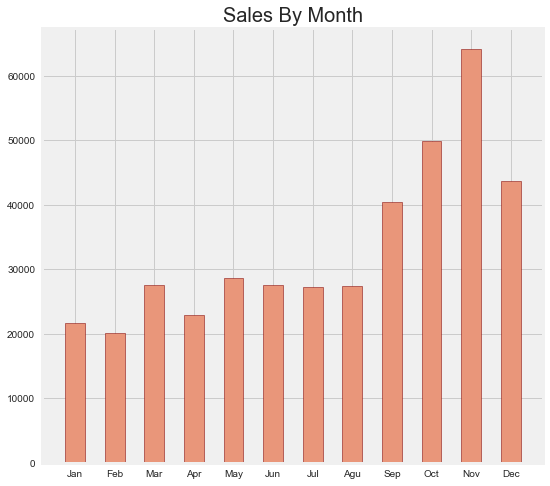

In [15]:
sorted_month_count = df_initial['month'].value_counts().sort_index()

plt.figure(figsize=(8, 8))
plt.bar(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Agu", "Sep", "Oct", "Nov", "Dec"],
        sorted_month_count.values,
        color="darksalmon", 
        edgecolor="maroon",
        width=0.5)
plt.title("Sales By Month", fontsize = 20);

After that I plotted counts of sales per month in my dataset. As you can see above it didn't distributed uniformly too. If you give attention at last months of year, you can notice that sales are a bit higher than other months. We can observe that customers are doing shopping for winter or for christmas generally. But still we can't be sure about it. 

To get more detailed observation, I grouped months according to seasons and plotted sale counts per season too.

In [16]:
counts = df_initial['month'].value_counts()
summer = counts[6] + counts[7] + counts[8]
winter = counts[12] + counts[1] + counts[2]
spring = counts[3] + counts[4] + counts[5]
autumn = counts[9] + counts[10] + counts[11]

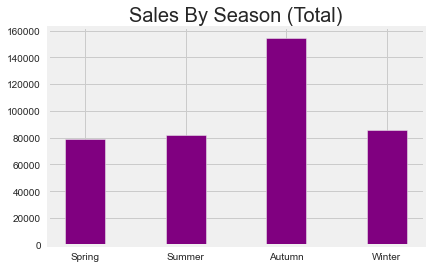

In [17]:
plt.bar(["Spring", "Summer", "Autumn", "Winter"], [spring, summer, autumn, winter], color ='purple',width = 0.4)
plt.title("Sales By Season (Total)", fontsize = 20);

Here we can observe distribution of sales much more clearly. We can say that sales peaked in "Autumn" season while they distributed almost uniformly in other seasons. So it strengthen our prediction about "winter preparing" sales.

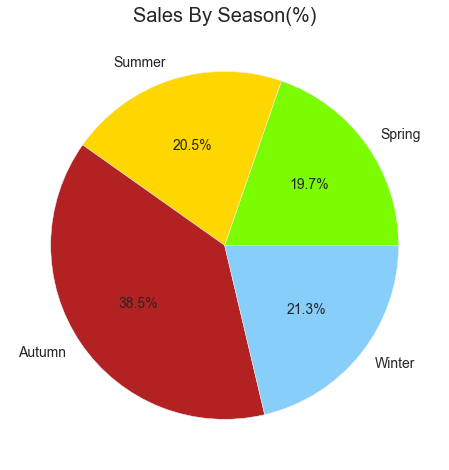

In [18]:
plt.figure(figsize=(8, 8))

plt.pie([spring, summer, autumn, winter],
        labels=["Spring", "Summer", "Autumn", "Winter"], 
        autopct='%.1f%%',textprops={'fontsize': 14},
        colors=["lawngreen", "gold", "firebrick", "lightskyblue"])

plt.title("Sales By Season(%)", fontsize = 20);

I plotted it as pie chart too to observe not only counts of sales per season but also percentages of them.

##### Refund Percentage of Products

As I explained in "descriptions of columns" part at the beginning, my dataset contains refunds within sells. So I wanted to visualize which product it more prone to be refunded.

In [19]:
refund_count = len(df_initial.loc[df_initial['InvoiceNo'].str[0] == 'C'])
not_refund_count = len(df_initial) - refund_count

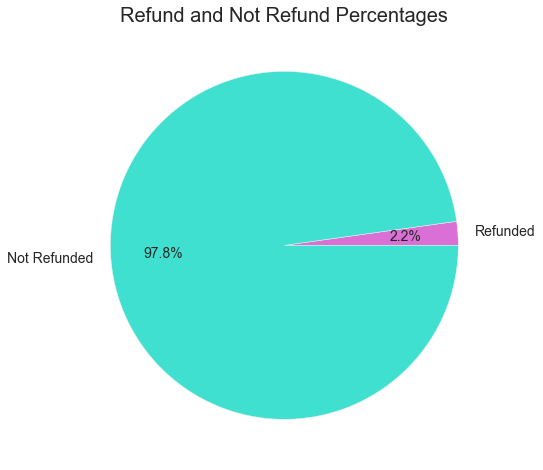

In [20]:
plt.figure(figsize=(8, 8))

plt.pie([refund_count, not_refund_count],
        labels=["Refunded", "Not Refunded"], 
        autopct='%.1f%%',textprops={'fontsize': 14}, 
        colors=["orchid", "turquoise"],
        pctdistance=0.7)

plt.title("Refund and Not Refund Percentages", fontsize = 20);

First of all I plotted comparison of refunded and not refunded product percentages. And I observed that 2.2% of my dataset consists of refunding processes.

In [21]:
refunds = df_initial.loc[df_initial['InvoiceNo'].str[0] == 'C'][["Description", "Quantity"]]
refunds_sum = refunds.groupby('Description').sum().sort_values(by=['Quantity'])[:10]
refunds_count = refunds.groupby('Description').count().sort_values(by=['Quantity'], ascending=False)[:10]

Then I created 2 more dataframe which are "Sum of Refunds" and "Count of Refunds". "Sum of Refunds" contains all of the refunds in my dataset (which can contain more than one refund in a transaction) while "Count of Refunds" contains refund of a product per transaction.

In [22]:
refunds_sum

Quantity
Description                                  
PAPER CRAFT , LITTLE BIRDIE            -80995
MEDIUM CERAMIC TOP STORAGE JAR         -74494
ROTATING SILVER ANGELS T-LIGHT HLDR     -9367
Manual                                  -3995
FAIRY CAKE FLANNEL ASSORTED COLOUR      -3150
WHITE HANGING HEART T-LIGHT HOLDER      -2578
GIN + TONIC DIET METAL SIGN             -2030
HERB MARKER BASIL                       -1527
FELTCRAFT DOLL MOLLY                    -1447
TEA TIME PARTY BUNTING                  -1424

In [23]:
refunds_count

Quantity
Description                                
REGENCY CAKESTAND 3 TIER                180
Manual                                  175
POSTAGE                                  97
JAM MAKING SET WITH JARS                 86
Discount                                 77
SET OF 3 CAKE TINS PANTRY DESIGN         72
STRAWBERRY CERAMIC TRINKET BOX           54
ROSES REGENCY TEACUP AND SAUCER          53
RECIPE BOX PANTRY YELLOW DESIGN          47
JUMBO BAG RED RETROSPOT                  44

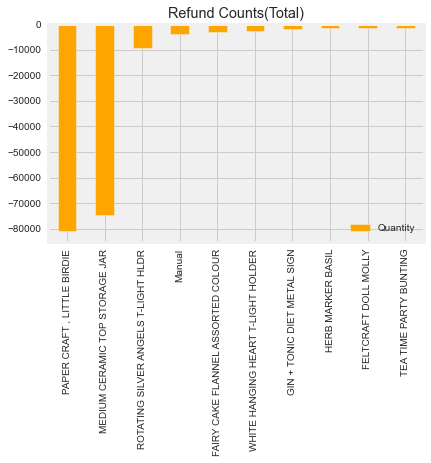

In [24]:
refunds_sum.plot.bar(color="orange")
plt.title("Refund Counts(Total)")
plt.xlabel("")
plt.legend(loc=4);

Here I plotted "Sum of Refunds". I plotted it downwards to emphasize that these it a graph of refunded products. And I observed that the most refunded product is 'PAPER CRAFT , LITTLE BIRDIE'.

Example of 'PAPER CRAFT , LITTLE BIRDIE'


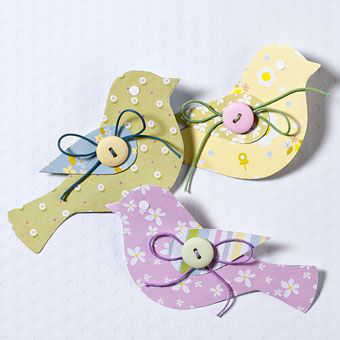

In [25]:
print("Example of 'PAPER CRAFT , LITTLE BIRDIE'")
im = Image.open(requests.get("https://i.pinimg.com/originals/47/b1/d8/47b1d84c307eb7d600b6704762f4321b.jpg", stream=True).raw)
display(im)

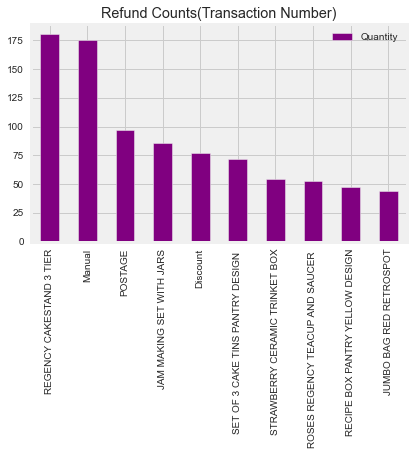

In [26]:
refunds_count.plot.bar(color="purple")
plt.title("Refund Counts(Transaction Number)")
plt.xlabel("");

Here I plotted "Count of Refunds".And I observed that the product refunded by the most people is 'REGENCY CAKESTAND 3 TIER'.

Example of 'REGENCY CAKESTAND 3 TIER'


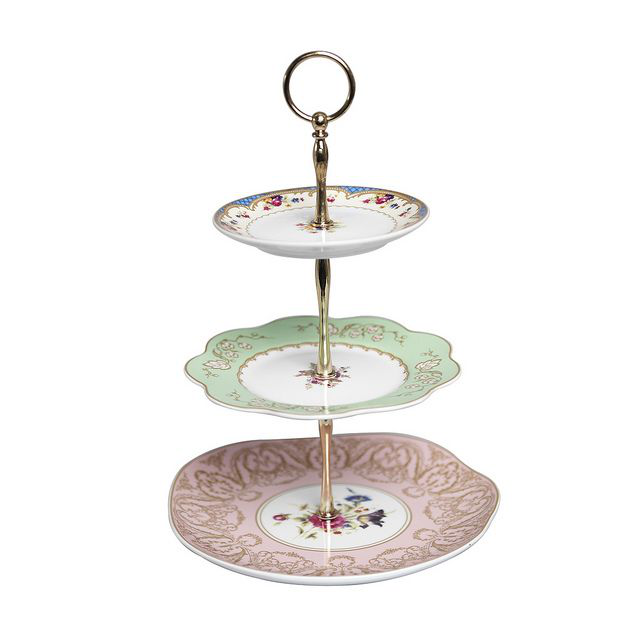

In [27]:
print("Example of 'REGENCY CAKESTAND 3 TIER'")
im = Image.open(requests.get("https://i.pinimg.com/originals/7c/15/42/7c1542e8daba0ef7e024981d7d4ff567.jpg", stream=True).raw)
display(im)

According to last 2 graphs above, while 'PAPER CRAFT , LITTLE BIRDIE' is the most refunded product, it is not be refunded by too many people because it didn't be displayed in second graph.

##### Grouping Sales By Country

Here I grouped sales by country to observe which countries this dataset includes sales to.

In [28]:
each_shopping = df_initial[['CustomerID', 'InvoiceNo', 'Country']]
each_shopping.head()

CustomerID InvoiceNo         Country
0       17850    536365  United Kingdom
1       17850    536365  United Kingdom
2       17850    536365  United Kingdom
3       17850    536365  United Kingdom
4       17850    536365  United Kingdom

In [29]:
countries = each_shopping['Country'].value_counts()

In [30]:
print("Number of different countries shopping :" , len(countries))

Number of different countries shopping : 37


Here I displayed how many contries does this dataset contain.

In [31]:
print("Top 5 shopping countries :")
print(countries.head())

Top 5 shopping countries :
United Kingdom    356728
Germany             9480
France              8475
Ireland             7475
Spain               2528
Name: Country, dtype: int64


Then I sorted top 5 most shopping countries according to my dataset. As you can see from this ranking table, my dataset mainly includes sales to 'United Kingdom'.

In [32]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order Number'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

In order to observe it better, I plotted geographical map by using "plotly" library. It shows order number per country and displays it with different colors according to order count. 

In [33]:
refunds_customer = df_initial.loc[df_initial['InvoiceNo'].str[0] == 'C'][["Country", "Quantity"]]

Then I wanted to investigate refund percentages by country.

In [34]:
refund_count_by_country = refunds_customer['Country'].value_counts().astype(int)
print("Top 5 refunding countries :")
print(refund_count_by_country.head())

Top 5 refunding countries :
United Kingdom    7501
Germany            453
Ireland            247
France             148
USA                112
Name: Country, dtype: int32


In [35]:
data = dict(type='choropleth',
locations = refund_count_by_country.index,
locationmode = 'country names', z = refund_count_by_country,
text = refund_count_by_country.index, colorbar = {'title':'Refund Count'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of refunds per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

And I plotted geographical map again but this time for refund counts.

But it didn't give ne so much imformation because it shows that most of the refunds are from "United Kingdom" naturally because most of sale records in my dataset from "United Kingdom". So I decided to investigate percentage of refunds per country.

In [36]:
df_each_ct = pd.concat([countries.rename("Sales"), refund_count_by_country.rename('Refunds')], axis=1).reset_index().fillna(0)
df_each_ct.rename(columns = {'index':'Countries'}, inplace = True)

In [37]:
df_each_ct["Refunds(%)"] = round(df_each_ct["Refunds"] / df_each_ct["Sales"] * 100, 1)
df_each_ct = df_each_ct.sort_values(by=["Refunds(%)"], ascending=False)[:5]
df_each_ct = df_each_ct.astype({"Refunds": "int"})

In [38]:
df_each_ct

Countries  Sales  Refunds  Refunds(%)
20             USA    291      112        38.5
34  Czech Republic     30        5        16.7
27           Malta    127       15        11.8
18           Japan    358       37        10.3
36    Saudi Arabia     10        1        10.0

As you can see above nearly 40% of orders are refunded from USA citizens. This may be due to problems arising from transoceanic product delivery.

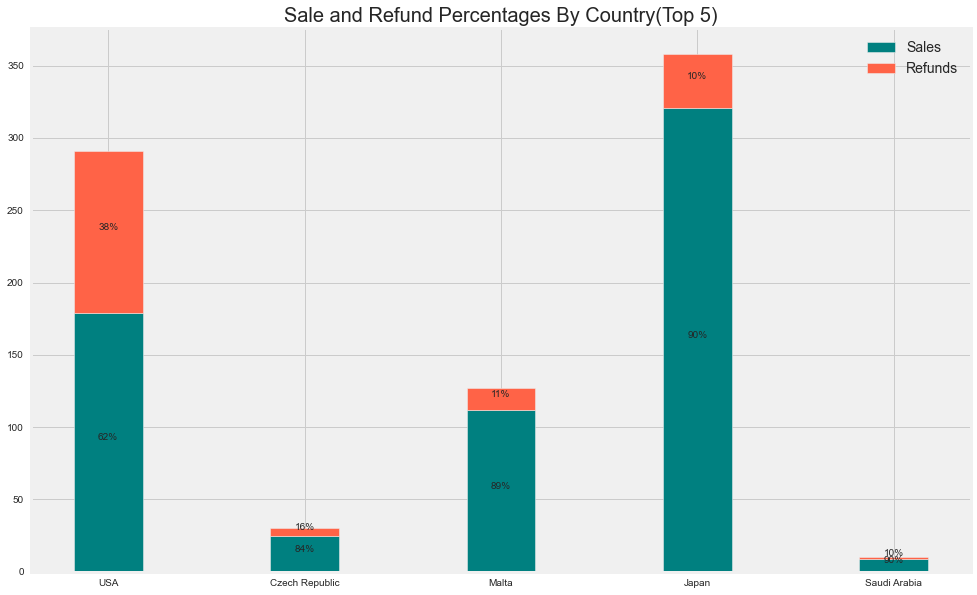

In [39]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
width = 0.35
rects1 = ax.bar(df_each_ct["Countries"], (df_each_ct["Sales"] - df_each_ct["Refunds"]), width, color="teal")
rects2 = ax.bar(df_each_ct["Countries"], df_each_ct["Refunds"], width, bottom=(df_each_ct["Sales"] - df_each_ct["Refunds"]), color="tomato")
for r1, r2 in zip(rects1, rects2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    percent = int(h2 * 100 / (h1+h2))
    percent2 = 100 - percent
    ax.annotate('{}%'.format(percent2),
                    xy=(r1.get_x() + r1.get_width() / 2, h1/2),
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='center', va='bottom')
    ax.annotate('{}%'.format(percent),
                    xy=(r2.get_x() + r2.get_width() / 2, h1+h2/2),
                    xytext=(0, 0), 
                    textcoords="offset points",
                    ha='center', va='bottom')
plt.title("Sale and Refund Percentages By Country(Top 5)",fontsize= 20)
plt.legend(df_each_ct.columns[1:],fontsize= 14)
plt.show()

In order to display it more clearly, I plotted percentages of sales and refunds of top countries that refund.

# Clustering(Without Binning)

In this phase, I started customer segmentation with clustering. There are several ways to perform customer segmentation, but some common methods include:<br>

-Demographic segmentation: dividing customers into groups based on characteristics such as age, gender, income, and education level.<br>

-Behavioral segmentation: grouping customers based on their purchasing behavior, such as brand loyalty, purchasing frequency, and customer lifetime value.<br>

-Psychographic segmentation: dividing customers into groups based on their lifestyle, values, and personality.<br>

-Geographic segmentation: grouping customers based on where they live or work.<br>

-Firmographic segmentation: segmenting customers by their company size, industry, and revenue.

### RFM Analysis (Recency, Frequency, Monetary)

In this project I used RFM technique which is one of the behavioral segmentation methods. RFM (Recency, Frequency, Monetary) segmentation is a method of customer segmentation that groups customers based on their past purchase behavior. Specifically, it segments customers based on how recently they made a purchase (Recency), how often they make purchases (Frequency), and how much they spend (Monetary).

In [40]:
df_initial.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

   UnitPrice  CustomerID         Country  year  month  
0       2.55       17850  United Kingdom  2010     12  
1       3.39       17850  United Kingdom  2010     12  
2       2.75       17850  United Kingdom  2010     12  
3       3.39       17850  United Kingdom  2010     12  
4       3.39       17850  United Kingdom  2010     12

In order to use it, I created new datasets called "recency", "frequency", "monetary" of per customer and concatenated them at the final phase to use in clustering phase.

In [41]:
#Reference Date : 01/2012
df_initial["how_many_months_ago"] = (2011 - df_initial["year"])*12 + (13 - df_initial["month"])
df_initial.drop(["year", "month"], axis=1, inplace=True)

In the above, I took reference date as "01/2012" because my dataset contains records from "01/2010" to "12/2011".

In [42]:
recency = df_initial[["CustomerID", "how_many_months_ago"]]
frequency = df_initial[["CustomerID", "InvoiceNo"]]
monetary = df_initial[["CustomerID", "Quantity", "UnitPrice"]]

In [43]:
recency.drop_duplicates(subset=['CustomerID'], keep='last',inplace = True)
recency = recency.sort_values(by=['CustomerID'])
recency.set_index('CustomerID',inplace=True)

In [44]:
frequency.drop_duplicates(subset=['InvoiceNo'], keep='last',inplace = True)
frequency = frequency.groupby('CustomerID').count().sort_values(by=['CustomerID'])
frequency.rename(columns = {'InvoiceNo':'frequency'}, inplace = True)

In [45]:
monetary["Total_spend"] = monetary["Quantity"] * monetary["UnitPrice"]
monetary.drop(["Quantity", "UnitPrice"], axis=1, inplace=True)
monetary = monetary.groupby('CustomerID').sum().sort_values(by=['CustomerID'])

In [46]:
rfm_data = pd.concat([recency, frequency, monetary], axis=1)
rfm_data.head()

how_many_months_ago  frequency  Total_spend
CustomerID                                             
12346                        12          2         0.00
12347                         1          7      4310.00
12348                         4          4      1797.24
12349                         2          1      1757.55
12350                        11          1       334.40

After creating "recency", "frequency", "monetary" datasets, I concatenated them under "rfm_data".

In [47]:
rfm_data.reset_index(drop=True, inplace=True)

I dropped "customerID" here because I won't need it in clustering phase.

In [48]:
rfm_data.head()

how_many_months_ago  frequency  Total_spend
0                   12          2         0.00
1                    1          7      4310.00
2                    4          4      1797.24
3                    2          1      1757.55
4                   11          1       334.40

In [49]:
# create an instance of the MinMaxScaler
scaler = MinMaxScaler()

# fit the scaler to the dataframe
scaler.fit(rfm_data)

# transform the dataframe and store it in a new variable
rfm_data = scaler.transform(rfm_data)
rfm_data = pd.DataFrame(rfm_data, columns=['recency', 'frequency', 'monetary'])
rfm_data["recency"] = 1 - rfm_data["recency"]
rfm_data.head()

recency  frequency  monetary
0  0.083333   0.004049  0.015109
1  1.000000   0.024291  0.030297
2  0.750000   0.012146  0.021442
3  0.916667   0.000000  0.021303
4  0.166667   0.000000  0.016288

Then I made min-max normalization to my dataset. min-max normalization, is a technique used to transform the values of a dataset into a specific range, typically the range (0, 1). The process involves subtracting the minimum value in the dataset from all the values, and then dividing the resulting values by the range (i.e., the difference between the maximum and minimum values). I used it on my dataset because all columns wasn't varied in equal range and it could cause bias.

After normalization, I finished my work on dataset and passed to clustering phase.

### K-Means Clustering

Firstly, I used partitioning clustering technique on my dataset with an algorithm called "K-Means". "K-Means" is a clustering algorithm used to group similar data points together into clusters. The algorithm works by defining spherical clusters, where each cluster is associated with a centroid. The centroid is the mean of all the points in a cluster. The main idea behind K-means is to minimize the sum of distances between the points in a cluster and their corresponding centroid.

To decide cluster number in K-Means clustering algorithm, we can use "elbow" method or "silhouette score" method.

##### With Elbow Method

The elbow method is a technique used to determine the optimal number of clusters in a k-means clustering algorithm. The idea behind the elbow method is to run k-means clustering on a dataset for a range of values of k (number of clusters) and for each value of k, calculate the sum of squared errors (SSE) between the data points and their closest cluster centroid.<br>

The SSE value will decrease as the number of clusters increases, but at some point, the decrease in SSE will not be significant enough to justify the increase in the number of clusters. The "elbow" point on the plot of SSE values against the number of clusters represents the optimal number of clusters. The value of k at which the change in SSE begins to level off is chosen as the optimal number of clusters.

In [50]:
distortions = []

K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(rfm_data)
  
    distortions.append(sum(np.min(cdist(rfm_data, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / rfm_data.shape[0])

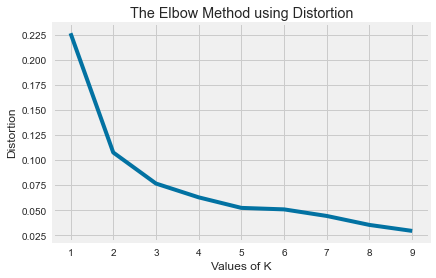

In [51]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

As you can see above, the change of SSE at "k=5" decreased to almost 0. So I decided cluster number as 5.

In [52]:
#Initialize the class object
kmeans = KMeans(n_clusters= 5)
 
#predict the labels of clusters.
label = kmeans.fit_predict(rfm_data)

In [53]:
rfm_data["cluster"] = label

In [54]:
rfm_data.head()

recency  frequency  monetary  cluster
0  0.083333   0.004049  0.015109        4
1  1.000000   0.024291  0.030297        3
2  0.750000   0.012146  0.021442        0
3  0.916667   0.000000  0.021303        3
4  0.166667   0.000000  0.016288        4

In [55]:
fig = px.scatter_3d(rfm_data, x="recency", y="frequency", z="monetary", color="cluster")
fig.show()

After clustering my dataset with K-Means algorithm to 5 different classes, I plotted it with "plotly" library as a 3D scatter plot. After I investigate it, I noticed that it used only recency attribute for clustering. So I couldn't get a proper clustering here.

In [56]:
rfm_data.drop(["cluster"], axis=1, inplace=True)

##### With Silhouette Score Method

The silhouette score is a measure of the similarity of an object to its own cluster compared to other clusters. It is a metric used to evaluate the performance of a clustering algorithm, specifically when applied to a dataset with a known number of clusters.<br>

The silhouette score ranges from -1 to 1, where a high silhouette score indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters, and a low silhouette score indicates that the object may have been assigned to the wrong cluster.<br>

The silhouette score is calculated for each object in the dataset, and the mean silhouette score across all objects is used as the overall measure of the quality of the clustering.

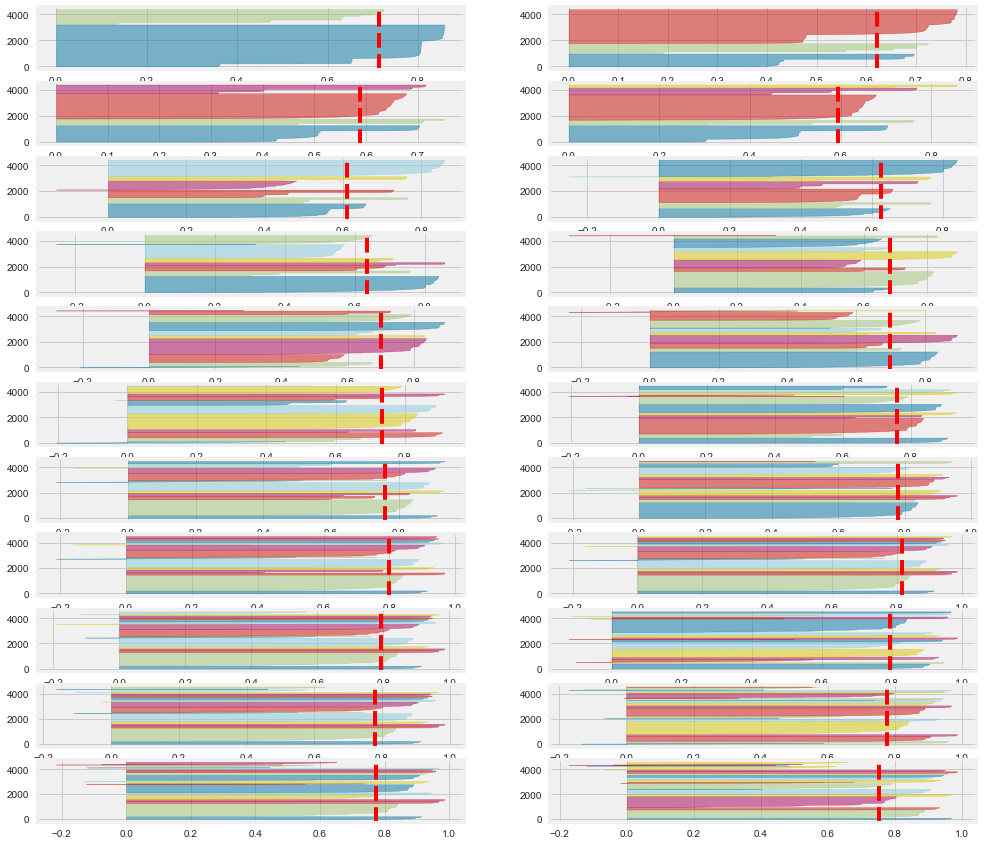

In [57]:
silhouette_scores = []

fig, ax = plt.subplots(11, 2, figsize=(15,15))
for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,16,17,18,19,20,21,22,23]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(rfm_data)
    silhouette_scores.append(visualizer.silhouette_score_)

I couldn't observe mean silhouette scores from graphs. So I printed mean silhouette scores as a table below.

In [58]:
print("Silhouette Scores:")
sayac = 2
for i in silhouette_scores:
    print("For {} clusters :".format(sayac), i)
    sayac += 1

Silhouette Scores:
For 2 clusters : 0.7140481996765542
For 3 clusters : 0.6205811835511927
For 4 clusters : 0.5886453337744479
For 5 clusters : 0.5946187201582798
For 6 clusters : 0.6104218587065058
For 7 clusters : 0.6260455708987416
For 8 clusters : 0.6357899073492529
For 9 clusters : 0.681396507909672
For 10 clusters : 0.6988769577653412
For 11 clusters : 0.6985701976941494
For 12 clusters : 0.7348410703756304
For 13 clusters : 0.7592595356711997
For 14 clusters : 0.7604524093289703
For 15 clusters : 0.7813748896223387
For 16 clusters : 0.7973649793604435
For 17 clusters : 0.8150745688996254
For 18 clusters : 0.7937024990699985
For 19 clusters : 0.7943566259670136
For 20 clusters : 0.7796308854245028
For 21 clusters : 0.7779892373955293
For 22 clusters : 0.77346570669166
For 23 clusters : 0.7537020306318702


As you can see in the table above, the highest silhouette score is at 17 clusters. So I decided the cluster number as 17.

In [59]:
#Initialize the class object
kmeans = KMeans(n_clusters= 17)
 
#predict the labels of clusters.
label = kmeans.fit_predict(rfm_data)

In [60]:
rfm_data["cluster"] = label

In [61]:
rfm_data.head()

recency  frequency  monetary  cluster
0  0.083333   0.004049  0.015109       14
1  1.000000   0.024291  0.030297        6
2  0.750000   0.012146  0.021442        9
3  0.916667   0.000000  0.021303        1
4  0.166667   0.000000  0.016288        2

In [62]:
fig1 = px.scatter_3d(rfm_data, x="recency", y="frequency", z="monetary", color="cluster")
fig1.show()

After clustering my dataset with K-Means algorithm to 17 different classes, I plotted it with "plotly" library as a 3D scatter plot. After I investigate it, I am convinced that this graph is a very successful graph in terms of customer segmentation and can be used in the conclusion part.

In [63]:
rfm_data.drop(["cluster"], axis=1, inplace=True)

### Hierarchical Clustering

After partitioning clustering, I tried "hierarchical clustering" technique on my dataset.

Hierarchical clustering is a type of clustering algorithm that builds a hierarchy of clusters, where each cluster is divided into smaller clusters until each data point belongs to its own cluster. There are two main types of hierarchical clustering:<br>

-Agglomerative: This is a "bottom-up" approach, where each data point is initially considered as its own cluster, and clusters are iteratively merged together based on some similarity measure (e.g. euclidean distance) until all points belong to a single cluster or a stopping criterion is met.<br>

-Divisive: This is a "top-down" approach, where all data points are initially in the same cluster and the algorithm recursively divides the cluster into smaller clusters until each data point belongs to its own cluster or a stopping criterion is met.

In this project I used Agglomerative clustering algorithm. To use it, we must decide cluster number as we did in K-Means clustering. But this time we can use "dendrogram analysing" technique to decide cluster number.

##### With Dendrogram Analysing

A dendrogram is a tree-like representation of the hierarchical clustering that is commonly used to visualize the relationships between the clusters. In dendrograms, each leaf node represents a single data point and each non-leaf node represents a cluster of data points. The height of the nodes in the dendrogram represents the similarity or dissimilarity between the clusters.<br>

One technique to determine the number of clusters from a dendrogram is to look for a "natural" break or "elbow" in the dendrogram, which corresponds to a significant change in the height of the nodes. This break point represents the point at which merging additional clusters would not result in a significant increase in similarity.

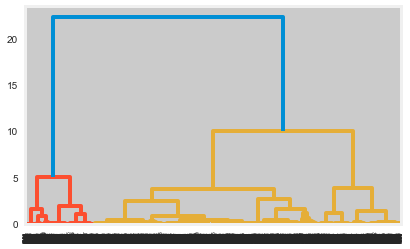

In [64]:
linkage_data = linkage(rfm_data, method='ward', metric='euclidean')
dendrogram(linkage_data)

plt.show()

As you can see in dendrogram graph, 3 cluster would be appropriate for clustering.

In [65]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(rfm_data)

In [66]:
rfm_data["cluster"] = labels

In [67]:
rfm_data.head()

recency  frequency  monetary  cluster
0  0.083333   0.004049  0.015109        0
1  1.000000   0.024291  0.030297        2
2  0.750000   0.012146  0.021442        1
3  0.916667   0.000000  0.021303        2
4  0.166667   0.000000  0.016288        0

In [68]:
fig = px.scatter_3d(rfm_data, x="recency", y="frequency", z="monetary", color="cluster")
fig.show()

After clustering my dataset with Agglomerative clustering algorithm to 3 different classes, I plotted it with "plotly" library as a 3D scatter plot. After I investigate it, I noticed that it used only recency attribute for clustering. So I couldn't get a proper clustering here.

In [69]:
rfm_data.drop(["cluster"], axis=1, inplace=True)

# Clustering (With Binning)

Binning is a technique used to handle numerical attributes in data pre-processing. It involves grouping a set of numerical values into a smaller number of "bins" or intervals. For example, instead of working with a continuous range of ages, you could group ages into bins such as "0-10", "11-20", "21-30", etc. This is a useful tool for reducing the dimensionality of the data so I tried to use it for clustering my dataset.

In [70]:
rfm_data

recency  frequency  monetary
0     0.083333   0.004049  0.015109
1     1.000000   0.024291  0.030297
2     0.750000   0.012146  0.021442
3     0.916667   0.000000  0.021303
4     0.166667   0.000000  0.016288
...        ...        ...       ...
4367  0.250000   0.000000  0.015746
4368  0.500000   0.000000  0.015394
4369  1.000000   0.008097  0.015731
4370  1.000000   0.060729  0.022317
4371  0.833333   0.008097  0.021584

[4372 rows x 3 columns]

In the below, I converted my attributes to categorical by using "Equal Frequency" binning. Equal frequency binning, also known as equal width binning, is a method of binning numerical data where each bin contains roughly the same number of data points. The range of the data is divided into a fixed number of intervals or bins, each with the same size or width.

In [71]:
rfm_data["recency"] = pd.qcut(
    x=rfm_data["recency"],
    q=3,
    labels=[0, 0.5, 1])

In [72]:
rfm_data["frequency"] = pd.qcut(
    x=rfm_data["frequency"],
    q=3,
    labels=[0, 0.5, 1])
rfm_data["monetary"] = pd.qcut(
    x=rfm_data["monetary"],
    q=3,
    labels=[0, 0.5, 1])

In [73]:
rfm_data

recency frequency monetary
0        0.0       0.0      0.0
1        1.0       1.0      1.0
2        0.0       0.5      1.0
3        0.5       0.0      1.0
4        0.0       0.0      0.0
...      ...       ...      ...
4367     0.0       0.0      0.0
4368     0.0       0.0      0.0
4369     1.0       0.5      0.0
4370     1.0       1.0      1.0
4371     0.5       0.5      1.0

[4372 rows x 3 columns]

In [74]:
rfm_data = rfm_data.astype({"recency": float,"frequency": float,"monetary": float})

After reducing dimensionality of my data, I used it in K-Means clustering algorithm again.

### K-Means Clustering

##### With Elbow Method

In [75]:
distortions = []
inertias = []

K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(rfm_data)
  
    distortions.append(sum(np.min(cdist(rfm_data, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / rfm_data.shape[0])
    inertias.append(kmeanModel.inertia_)

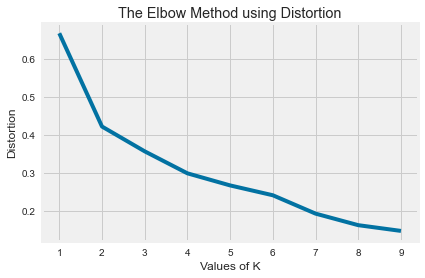

In [76]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [77]:
#Initialize the class object
kmeans = KMeans(n_clusters= 6)
 
#predict the labels of clusters.
label = kmeans.fit_predict(rfm_data)

In [78]:
rfm_data["cluster"] = label

In [79]:
rfm_data.head()

recency  frequency  monetary  cluster
0      0.0        0.0       0.0        4
1      1.0        1.0       1.0        5
2      0.0        0.5       1.0        1
3      0.5        0.0       1.0        1
4      0.0        0.0       0.0        4

In [80]:
fig = px.scatter_3d(rfm_data, x="recency", y="frequency", z="monetary", color="cluster")
fig.show()

After clustering my dataset with K-Means algorithm to 6 different classes, I plotted it with "plotly" library as a 3D scatter plot. After I investigate it, I noticed that it used only recency attribute for clustering. So I couldn't get a proper clustering here.

In [81]:
rfm_data.drop(["cluster"], axis=1, inplace=True)

##### With Silhouette Score Method

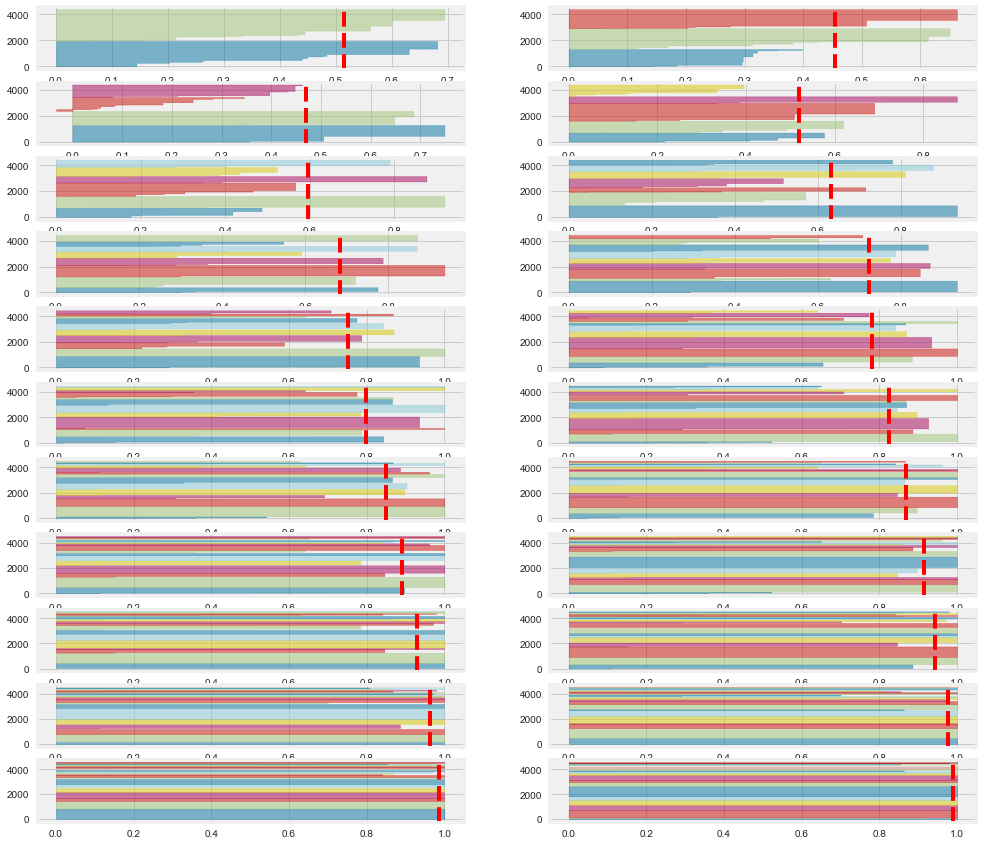

In [82]:
silhouette_scores = []

fig, ax = plt.subplots(11, 2, figsize=(15,15))
for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,16,17,18,19,20,21,22,23]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(rfm_data)
    silhouette_scores.append(visualizer.silhouette_score_)

In [83]:
print("Silhouette Scores:")
sayac = 2
for i in silhouette_scores:
    print("For {} clusters :".format(sayac), i)
    sayac += 1

Silhouette Scores:
For 2 clusters : 0.5156666193365761
For 3 clusters : 0.4550794673017993
For 4 clusters : 0.4697561995067785
For 5 clusters : 0.5187646798316171
For 6 clusters : 0.5962859639378963
For 7 clusters : 0.6308419626516112
For 8 clusters : 0.6845699184283788
For 9 clusters : 0.7236405063516677
For 10 clusters : 0.7512461066138203
For 11 clusters : 0.7819347198071257
For 12 clusters : 0.7980148907407889
For 13 clusters : 0.8263736363245996
For 14 clusters : 0.8492929696544872
For 15 clusters : 0.8677773486160822
For 16 clusters : 0.8911850962759358
For 17 clusters : 0.9143167805845785
For 18 clusters : 0.928928855365953
For 19 clusters : 0.9448179858251067
For 20 clusters : 0.9624316778169781
For 21 clusters : 0.9771701953886321
For 22 clusters : 0.98668839673693
For 23 clusters : 0.9910100076451641


In [84]:
#Initialize the class object
kmeans = KMeans(n_clusters= 8)
 
#predict the labels of clusters.
label = kmeans.fit_predict(rfm_data)

In [85]:
rfm_data["cluster"] = label

In [86]:
rfm_data.head()

recency  frequency  monetary  cluster
0      0.0        0.0       0.0        5
1      1.0        1.0       1.0        3
2      0.0        0.5       1.0        2
3      0.5        0.0       1.0        7
4      0.0        0.0       0.0        5

In [87]:
fig = px.scatter_3d(rfm_data, x="recency", y="frequency", z="monetary", color="cluster")
fig.show()

After clustering my dataset with K-Means algorithm to 8 different classes, I plotted it with "plotly" library as a 3D scatter plot. After I investigate it, I noticed that it used only recency attribute for clustering. So I couldn't get a proper clustering here.

In [88]:
rfm_data.drop(["cluster"], axis=1, inplace=True)

As a result of binned dataset clustering, I can say that I couldn't obtain significant clustering results.

# Conclusion

After trying vaious techniques and algorithms for customer segmentation, I decided to use results of K-Means with 17 different clusters.

In [89]:
fig1.show()

If I interpret a few of the clusters that were created:<br>

- <b>Cluster12 :</b> These costumers are shown in the plot with orange color. They are frequent shopper and it wasn't long after their last purchase. Therefore, we can say that they are our loyal customers and they still continue to shop from us. So they are important customers for us. They also seem happy with the current situation so we don't need to innovate for them.<br>

- <b>Cluster8 :</b> These costumers are shown in the plot with pink-red color. They are our recent and wealthy customers. They don't do shopping frequently but when they do, they spend too much money. So we can say that they buy wholesale products. These customers make up a large part of our market's income source, so we can say that they are our most important customers. <br>

- <b>Cluster9 :</b> These costumers are shown in the plot with red color at the bottom side of frequency axis. These are customers who made a small purchase long ago but have not re-purchased since. So we can say that these customers are not satisfied with our products or they find a better alternative for themselves and turn to it. But since they are never important customers for our market, we don't need to do new things for them either. <br>

- <b>Cluster16 :</b> These costumers are shown in the plot with yellow color at the bottom side of the intersection of all three axes. These are our new customers. For this reason, it is important for our market to gain new customers by providing them with a feeling of well-being.<br>